# Классификация изображений природы по времени года

**Проектная работа Ситникова Андрея на курсе «Machine Learning. Professional»**

## Часть 5. Классификация бинарной модели

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

np.random.seed(100)

In [2]:
df = pd.read_csv('df_ml.csv')
df

,season,c000,c001,c002,c003,c004,c005,c010,c011,c012,...,c542,c543,c544,c545,c550,c551,c552,c553,c554,c555
0,summer,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,summer,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,summer,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,summer,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,summer,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2338,spring,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2339,spring,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2340,spring,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2341,spring,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


Заменяем весну и осень на лето.

In [3]:
df.replace({'spring': 'summer', 'autumn': 'summer'}, inplace = True)

In [4]:
df['season'].value_counts()

summer    1773
winter     570
Name: season, dtype: int64

Делаем train-test разбиение.

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['season'], axis=1), df['season'], test_size=0.25, random_state=100, stratify=df['season']
)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1757, 216), (1757,), (586, 216), (586,))

### KNN

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, plot_confusion_matrix

In [18]:
def quality(true_y, prediction_y):
    accuracy = accuracy_score(true_y, prediction_y)
    precision = precision_score(true_y, prediction_y, average='weighted')
    recall = recall_score(true_y, prediction_y, average='weighted')
    f1 = f1_score(true_y, prediction_y, average='weighted')
    print("Accuracy:  {:.3f}\nPrecision: {:.3f}\nRecall:    {:.3f}\nF1-score:  {:.3f}".format(
        accuracy, precision, recall, f1
    ))

In [19]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
quality(y_test, knn.predict(X_test))

Accuracy:  0.761
Precision: 0.773
Recall:    0.761
F1-score:  0.766


Метрики качества ожидаемо заметно выросли.

              precision    recall  f1-score   support

      summer      0.858     0.819     0.838       443
      winter      0.509     0.580     0.542       143

    accuracy                          0.761       586
   macro avg      0.684     0.700     0.690       586
weighted avg      0.773     0.761     0.766       586



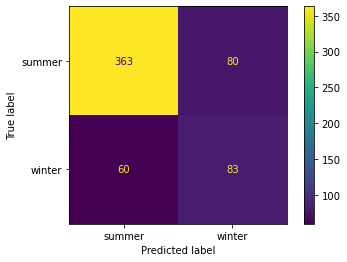

In [20]:
plot_confusion_matrix(knn, X_test, y_test)
print(classification_report(y_test, knn.predict(X_test), digits=3))

Precision и recall для лета оказались существенно выше, чем для зимы.

### Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
quality(y_test, log_reg.predict(X_test))

Accuracy:  0.809
Precision: 0.801
Recall:    0.809
F1-score:  0.804


Кросс-валидация.

In [26]:
from sklearn.linear_model import LogisticRegressionCV

log_reg_cv = LogisticRegressionCV(cv=5, scoring='f1_weighted', verbose=5, n_jobs=-1)
log_reg_cv.fit(X_train, y_train)

quality(y_test, log_reg_cv.predict(X_test))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.9s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished


Accuracy:  0.812
Precision: 0.802
Recall:    0.812
F1-score:  0.805


              precision    recall  f1-score   support

      summer      0.854     0.907     0.880       443
      winter      0.643     0.517     0.574       143

    accuracy                          0.812       586
   macro avg      0.748     0.712     0.727       586
weighted avg      0.802     0.812     0.805       586



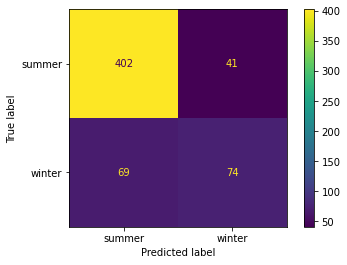

In [23]:
plot_confusion_matrix(log_reg_cv, X_test, y_test)
print(classification_report(y_test, log_reg_cv.predict(X_test), digits=3))

Метрики лучше, чем для KNN.

Сделаем настройку гиперпараметров.

In [28]:
%%time
from sklearn.model_selection import GridSearchCV

grid = {'penalty': ['l1', 'l2'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

log_reg_cv2 = GridSearchCV(estimator = log_reg, param_grid = grid, cv = 5, n_jobs = -1, verbose = 5)
log_reg_cv2.fit(X_train,y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  63 out of  70 | elapsed:    4.1s remaining:    0.4s


Wall time: 4.6 s


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    4.3s finished


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']},
             verbose=5)

In [29]:
log_reg_cv2.best_params_

{'C': 0.1, 'penalty': 'l2'}

In [43]:
quality(y_test, log_reg_cv2.predict(X_test))

Accuracy:  0.824
Precision: 0.813
Recall:    0.824
F1-score:  0.813


              precision    recall  f1-score   support

      summer      0.851     0.930     0.889       443
      winter      0.696     0.497     0.580       143

    accuracy                          0.824       586
   macro avg      0.774     0.713     0.734       586
weighted avg      0.813     0.824     0.813       586



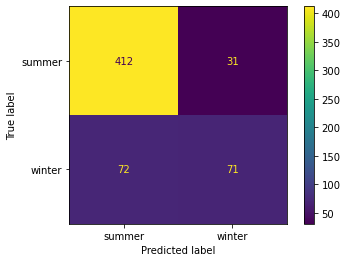

In [30]:
plot_confusion_matrix(log_reg_cv2, X_test, y_test)
print(classification_report(y_test, log_reg_cv2.predict(X_test), digits=3))

Настройка гиперпараметров внесла ещё некоторые улучшения качества.

### CatBoost

In [24]:
from catboost import CatBoostClassifier
cat = CatBoostClassifier()
cat.fit(X_train, y_train)
quality(y_test, cat.predict(X_test))

Learning rate set to 0.013105
0:	learn: 0.6857725	total: 182ms	remaining: 3m 2s
1:	learn: 0.6789017	total: 194ms	remaining: 1m 36s
2:	learn: 0.6716972	total: 200ms	remaining: 1m 6s
3:	learn: 0.6647286	total: 206ms	remaining: 51.2s
4:	learn: 0.6579931	total: 211ms	remaining: 41.9s
5:	learn: 0.6516118	total: 216ms	remaining: 35.7s
6:	learn: 0.6447971	total: 221ms	remaining: 31.3s
7:	learn: 0.6393134	total: 225ms	remaining: 27.9s
8:	learn: 0.6329893	total: 230ms	remaining: 25.3s
9:	learn: 0.6283454	total: 234ms	remaining: 23.2s
10:	learn: 0.6230411	total: 239ms	remaining: 21.5s
11:	learn: 0.6169993	total: 243ms	remaining: 20s
12:	learn: 0.6115700	total: 248ms	remaining: 18.8s
13:	learn: 0.6074507	total: 253ms	remaining: 17.8s
14:	learn: 0.6023747	total: 258ms	remaining: 16.9s
15:	learn: 0.5979926	total: 262ms	remaining: 16.1s
16:	learn: 0.5934064	total: 266ms	remaining: 15.4s
17:	learn: 0.5894909	total: 270ms	remaining: 14.7s
18:	learn: 0.5850433	total: 275ms	remaining: 14.2s
19:	learn: 0

              precision    recall  f1-score   support

      summer      0.854     0.914     0.883       443
      winter      0.661     0.517     0.580       143

    accuracy                          0.817       586
   macro avg      0.758     0.716     0.732       586
weighted avg      0.807     0.817     0.809       586



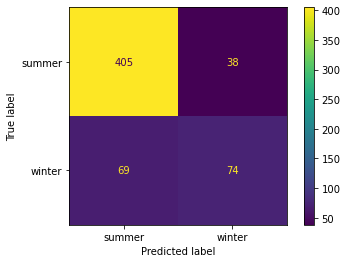

In [25]:
plot_confusion_matrix(cat, X_test, y_test)
print(classification_report(y_test, cat.predict(X_test), digits=3))

Для CatBoost из коробки качество на уровне логистической регрессии. Выполним тюнинг.

In [31]:
%%time
from sklearn.model_selection import GridSearchCV

grid = {'n_estimators': [100, 300, 500, 700, 900],
        'subsample': [0.6, 0.7, 0.8, 0.9, 1],
        'max_depth': [2, 4, 6, 8, 10]}

cat_cv = GridSearchCV(estimator = cat, param_grid = grid, cv = 5, n_jobs = -1, verbose = 5)
cat_cv.fit(X_train,y_train)
quality(cb.predict(X_test), y_test)

Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 16.6min
[Parallel(n_jobs=-1)]: Done 625 out of 625 | elapsed: 54.7min finished


Learning rate set to 0.108256
0:	learn: 0.6400242	total: 3.76ms	remaining: 372ms
1:	learn: 0.5982912	total: 15.4ms	remaining: 757ms
2:	learn: 0.5629758	total: 26.3ms	remaining: 850ms
3:	learn: 0.5333202	total: 37.2ms	remaining: 893ms
4:	learn: 0.5086052	total: 49.3ms	remaining: 937ms
5:	learn: 0.4847457	total: 61.3ms	remaining: 960ms
6:	learn: 0.4674001	total: 73.8ms	remaining: 981ms
7:	learn: 0.4603801	total: 77.1ms	remaining: 886ms
8:	learn: 0.4461487	total: 94ms	remaining: 950ms
9:	learn: 0.4365167	total: 108ms	remaining: 973ms
10:	learn: 0.4242481	total: 130ms	remaining: 1.05s
11:	learn: 0.4138402	total: 142ms	remaining: 1.04s
12:	learn: 0.4060427	total: 154ms	remaining: 1.03s
13:	learn: 0.4006674	total: 164ms	remaining: 1.01s
14:	learn: 0.3958860	total: 175ms	remaining: 990ms
15:	learn: 0.3908107	total: 189ms	remaining: 990ms
16:	learn: 0.3863936	total: 202ms	remaining: 988ms
17:	learn: 0.3831462	total: 213ms	remaining: 972ms
18:	learn: 0.3791989	total: 224ms	remaining: 957ms
19:	

NameError: name 'cb' is not defined

In [32]:
cat_cv.best_params_

{'max_depth': 8, 'n_estimators': 100, 'subsample': 1}

In [34]:
quality(y_test, cat_cv.best_estimator_.predict(X_test))

Accuracy:  0.819
Precision: 0.809
Recall:    0.819
F1-score:  0.811


              precision    recall  f1-score   support

      summer      0.856     0.914     0.884       443
      winter      0.664     0.524     0.586       143

    accuracy                          0.819       586
   macro avg      0.760     0.719     0.735       586
weighted avg      0.809     0.819     0.811       586



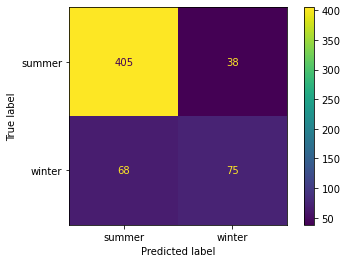

In [35]:
plot_confusion_matrix(cat_cv, X_test, y_test)
print(classification_report(y_test, cat_cv.predict(X_test), digits=3))

После настройки CatBoost качество почти не изменилось, ровно одна картинка зимы перешла в корректно угаданные.

### SVM

In [36]:
from sklearn import svm

svc = svm.SVC()
svc.fit(X_train, y_train)
quality(y_test, svc.predict(X_test))

Accuracy:  0.816
Precision: 0.805
Recall:    0.816
F1-score:  0.807


Метрики на уровне предыдущих двух алгоритмов. Выполним тюнинг.

In [37]:
%%time

grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'kernel': ['rbf', 'poly', 'sigmoid', 'linear'],
        'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}

svc_cv = GridSearchCV(estimator = svc, param_grid = grid, cv = 5, n_jobs = -1, verbose = 5)
svc_cv.fit(X_train,y_train)

Fitting 5 folds for each of 140 candidates, totalling 700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   47.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:  8.8min finished


Wall time: 8min 47s


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'poly', 'sigmoid', 'linear']},
             verbose=5)

In [38]:
svc_cv.best_params_

{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}

In [41]:
quality(y_test, svc_cv.best_estimator_.predict(X_test))

Accuracy:  0.816
Precision: 0.805
Recall:    0.816
F1-score:  0.807


              precision    recall  f1-score   support

      summer      0.851     0.916     0.883       443
      winter      0.661     0.503     0.571       143

    accuracy                          0.816       586
   macro avg      0.756     0.710     0.727       586
weighted avg      0.805     0.816     0.807       586



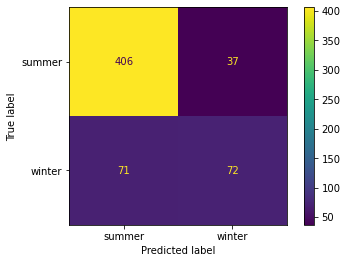

In [40]:
plot_confusion_matrix(svc_cv, X_test, y_test)
print(classification_report(y_test, svc_cv.predict(X_test), digits=3))

### Выводы

При выполнении проекта мы прошли следующие этапы:

1. Сбор данных — изображений, размеченных по временам года
2. Исследование собранных изображений на предмет того, каким способом из них лучше выделить признаки
3. Составление датафрейма с помощью кластеризации каждого изображения
4. Классификация полученного датафрейма с помощью различных алгоритмов
5. Классификация упрощённого датафрейма (из 4 значений целевой переменной оставили 2) с помощью различных алгоритмов

На 5 этапе получены приемлемые показатели качества. Из нескольких применённых алгоритмов машинного обучения модель с наилучшими метриками получилась от настроенной логистической регрессии.